# 딥드림

딥드림은 2015년, 구글에서 발표된, CNN을 이용한 이미지 변환 기술이다. 결과물에서 벌레나, 개, 새 등의 사물이 추상적으로 표현되고, 결과물의 전체적인 분위기가 몽환적인 분위기로 바뀐다. 덕분에, 당시 인터넷에 크게 유행 하기도 했다. 

딥드림은 기존의 CNN의 필터를 시각화하는 작업과 맥을 같이 한다. 이 책에서는 Inception-v3 모델을 이용해 이를 구현한다. 

## 구현 

  1. 모델에서 사용할 딥드림 변화에 사용할 레이어(layer)들과 각 레이어의 출력값에 곱해줄 가중치를 정한다. 
  2. CNN 필터가 찾은 특징을 강조하여 표현하기 위해서 컨볼루션 레이어의 출력값을 최대화 하는 전역적 경사상승법(Gradient Ascent)을 사용했다. 딥드림 에서는 한 레이어에만 이를 적용하는 것이 아니라 다수의 레이어에 대해 적용하여 많은 특징들을 한번에 표현한다.   
  3. 이미지가 더 잘 변환 될 수 있도록, 이미지를 여러 크기로 만들어 변환 한다. 크기 별로 이미지에서 추출 되는 특징들이 달라진다는 점을 이용한 것이다. 
  4. 실원본 이미지의 시각적인 패턴들이 어느정도 보존되게 하기 위해서, 반복 할 때 마다. 원본 이미지의 정보를 삽입한다. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
from keras.applications import inception_v3
from keras import backend as K
from keras.preprocessing import image
import tensorflow as tf 

# Scikit learn의 이미지 샘플 
from sklearn.datasets import load_sample_image
img = load_sample_image('flower.jpg') 

Using TensorFlow backend.


In [2]:
def resize_img(img, size):
    img = np.copy(img)
    factors = (1, float(size[0]) / img.shape[1], float(size[1]) / img.shape[2], 1)
    return sp.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    sp.misc.imsave(fname, pil_img)

def preprocess_image(img):
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    
    x = x.reshape((x.shape[1], x.shape[2], 3))
    
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [3]:
### Parameters 
step = 0.01
num_octave = 4
octave_scale = 1.4
iterations = 30
max_loss = 10.
result_fname = 'result_deepdream.jpeg'


with tf.Session() as sess:
    model = inception_v3.InceptionV3(include_top=False, weights='imagenet')
    K.set_learning_phase(0)

    # loss에 반영할 레이어 와 그에 해당하는 가중치 
    layer_contributions = {
        'mixed2': .3,
        'mixed3': 1.0,
        'mixed4': 1.5,
        'mixed5': 2,
    }

    loss = K.variable(0.)

    for layer_name in layer_contributions:

        coeff = layer_contributions[layer_name]
        x = model.get_layer(name=layer_name).output
        scaling = K.prod(K.cast(K.shape(x), 'float32'))
        
        # 이미지의 테두리에 의한 인위적인 변화를 포함 시키지 않도록 한다. 
        loss = loss + coeff * K.sum(K.square(x[:, 2:-2, 2:-2, :])) / scaling

    dream = model.input

    grads = K.gradients(loss, dream)[0]
    grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
    outputs = [loss, grads]
    fetch_loss_and_grads = K.Function([dream], outputs)
    
    def eval_loss_and_grads(x):
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1]
        return loss_value, grad_values

    def gradient_ascent(x, iterations, step, max_loss=None):

        for i in range(iterations):
            loss_value, grad_values = eval_loss_and_grads(x)
            if max_loss is not None and loss_value > max_loss:
                break
                print('...Loss value at', i, ':', loss_value)
            x += step * grad_values
        return x


    img = preprocess_image(img)

    original_shape = img.shape[1:3]
    successive_shapes = [original_shape]

    for i in range(1, num_octave):
        shape = tuple([int(dim / (octave_scale**i)) for dim in original_shape])
        successive_shapes.append(shape)

    successive_shapes = successive_shapes[::-1] # 스케일 리스트 

    original_img = np.copy(img)
    shrunk_original_img = resize_img(img, successive_shapes[0]) # starting from smallest image

    for shape in successive_shapes:
        print('Processing image shape', shape)
        img = resize_img(img, shape)
        img = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss)
        upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
        same_size_original = resize_img(original_img, shape)
        lost_detail = same_size_original - upscaled_shrunk_original_img
        img += lost_detail
        shrunk_original_img = resize_img(original_img, shape)

    image.save_img('result_deepdream.png', deprocess_image(np.copy(img)))

Processing image shape (155, 233)
Processing image shape (217, 326)
Processing image shape (305, 457)
Processing image shape (427, 640)


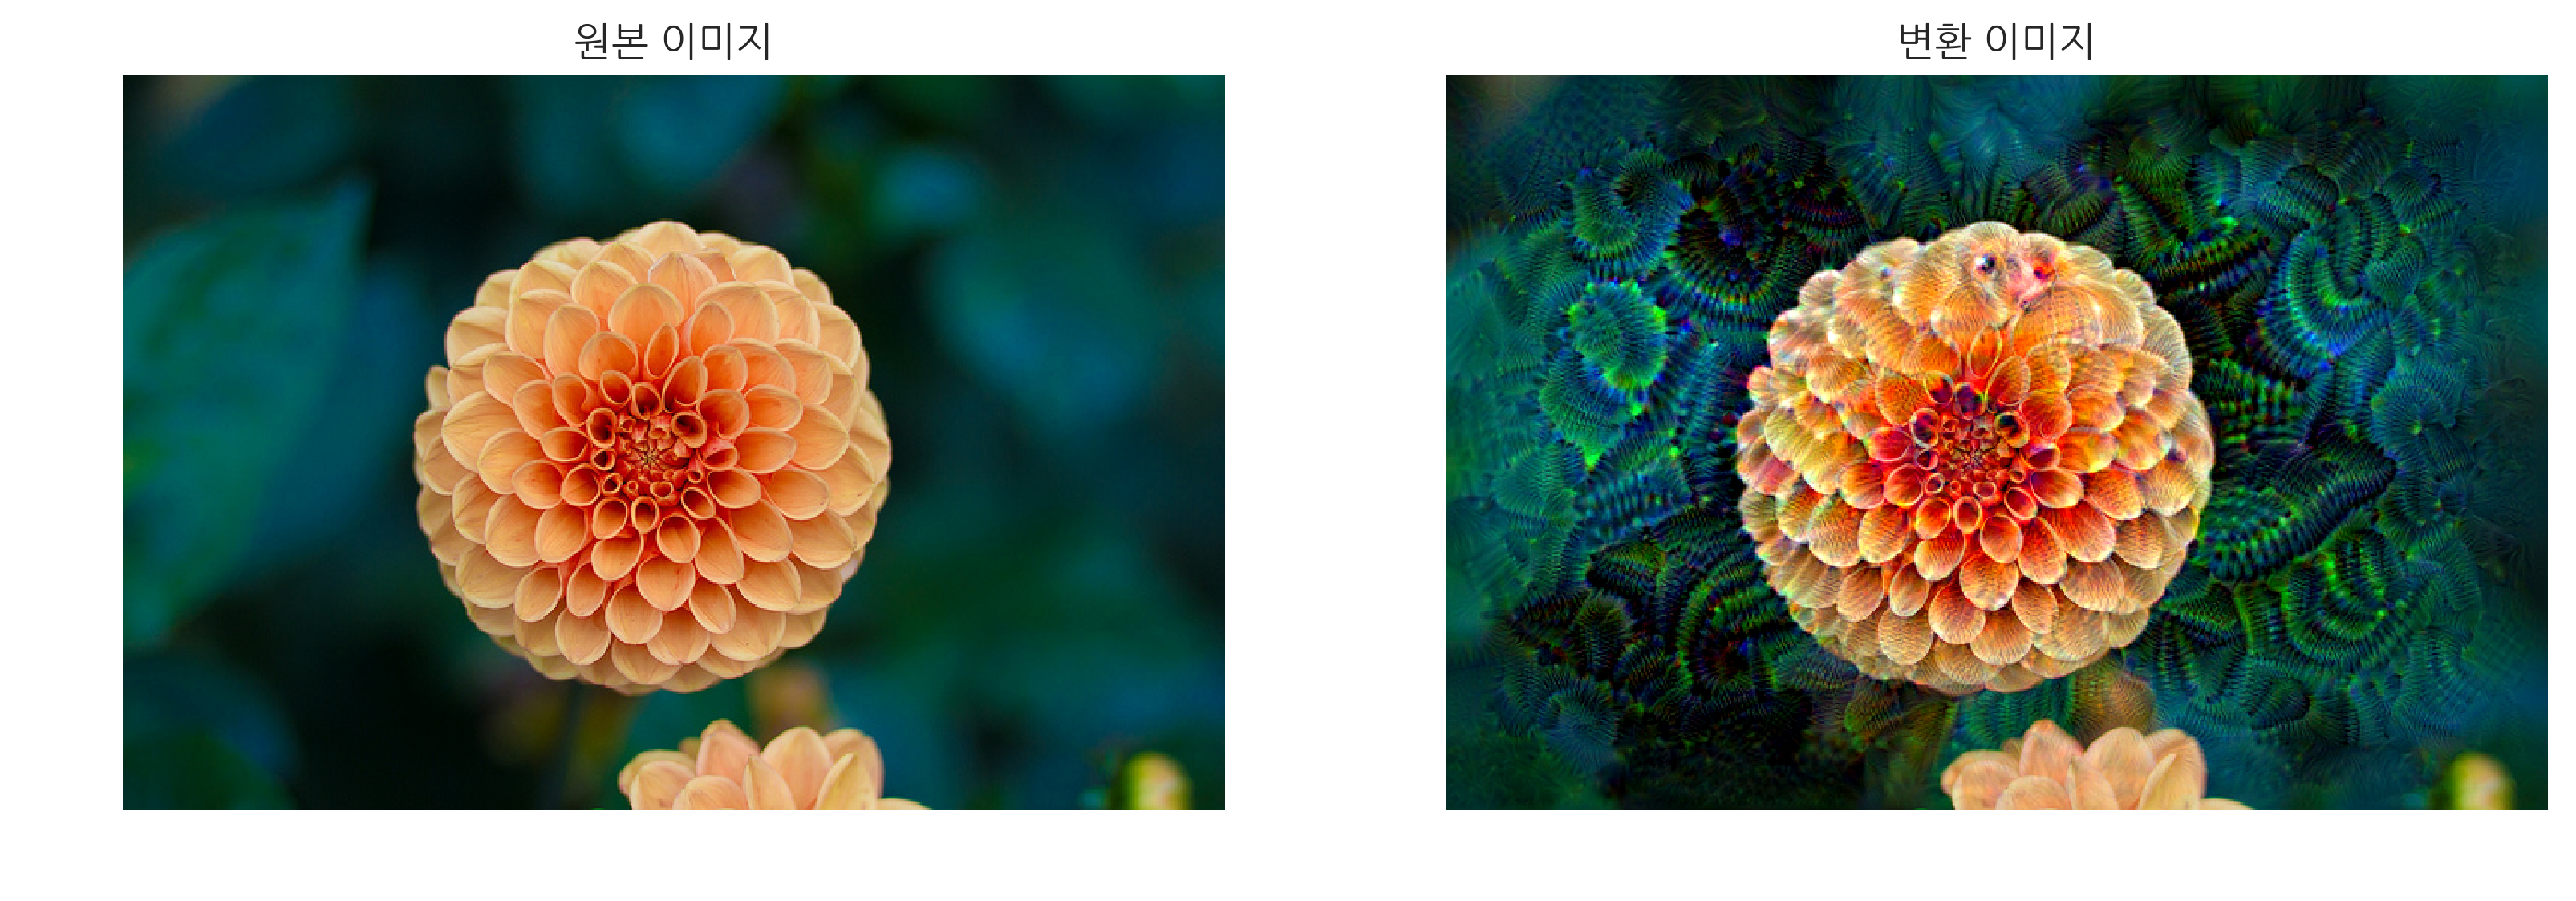

In [4]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 13))

ax1.imshow(deprocess_image(original_img))
ax1.set_axis_off()
ax1.set_title("원본 이미지")

ax2.imshow(deprocess_image(np.copy(img)))
ax2.set_axis_off()
ax2.set_title("변환 이미지")
plt.show()